# Part 2: Analyzing Oral Bioavailability - Lipinski's Rule of Five Evaluation of ChEMBL Compounds

This notebook aims to analyze and filter a dataset of compounds created in part 1 to identify orally bioavailable molecules using Lipinski's rule of five (Ro5). Lipinski's rule of five is a widely used guideline in drug discovery to assess the drug-likeness of a compound based on its physicochemical properties.

In [33]:
from pathlib import Path 
import math 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D 
import matplotlib.patches as mpatches 
from rdkit import Chem 
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams
from tqdm.auto import tqdm 

In [2]:
# read the file generated in part 1 
molecules = pd.read_csv("data/PIK3CA_compounds.csv", index_col=0) 
print(molecules.shape) 
molecules.head()

(4790, 6)


,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol
0,CHEMBL1236962,0.040,nM,COc1ncc(-c2ccc3nccc(-c4ccnnc4)c3c2)cc1NS(=O)(=...,10.397940,<rdkit.Chem.rdchem.Mol object at 0x2af52ad8d5f0>
1,CHEMBL3577914,0.070,nM,COc1ncc(-c2ccc3nc(N)nc(-c4ccncc4)c3c2)cc1NS(=O...,10.154902,<rdkit.Chem.rdchem.Mol object at 0x2af52ad8deb0>
2,CHEMBL3577911,0.095,nM,COc1ncc(-c2ccc3ncnc(-c4ccncc4)c3c2)cc1NS(=O)(=...,10.022276,<rdkit.Chem.rdchem.Mol object at 0x2af52ada52e0>
3,CHEMBL3577908,0.100,nM,COc1ncc(-c2ccc3nccc(-c4ccncc4)c3c2)cc1NS(=O)(=...,10.000000,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5350>
4,CHEMBL4878958,0.130,nM,COc1ncc2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1ccc...,9.886057,<rdkit.Chem.rdchem.Mol object at 0x2af52ada53c0>


## Ro5 Property Calculation

The calculate_ro5_properties function calculates various physicochemical properties for each compound, including molecular weight, the number of hydrogen bond acceptors (HBA), the number of hydrogen bond donors (HBD), and the logarithm of the octanol-water partition coefficient (logP). These properties are essential for Lipinski's rule of five evaluation.

In [3]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pd.Series
        Molecular weight, number of hydrogen bond acceptors/donors, 
        logP value, and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    
    # Check if Ro5 conditions are fulfilled
    ro5_fulfilled = (molecular_weight <= 500) and (n_hba <= 10) and (n_hbd <= 5) and (logp <= 5)
    
    # Return as pandas Series
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"]
    )


The compounds are evaluated against Lipinski's rule of five conditions, which include:

<br>Molecular weight <= 500</br>
<n>Number of HBA <= 10</n>
<br>Number of HBD <= 5</br>
<br>LogP <= 5</br>
If a compound meets at least three out of these four conditions, it is considered compliant with Ro5.

In [6]:
ro5_properties = molecules["smiles"].apply(calculate_ro5_properties)
ro5_properties.head()

,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,505.102017,7,1,4.84140,False
1,520.112916,8,2,4.42360,False
2,505.102017,7,1,4.84140,False
3,504.106768,6,1,5.44640,False
4,567.050495,9,2,4.98212,False


In [8]:
molecules = pd.concat([molecules, ro5_properties], axis=1) 
molecules.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
0,CHEMBL1236962,0.040,nM,COc1ncc(-c2ccc3nccc(-c4ccnnc4)c3c2)cc1NS(=O)(=...,10.397940,<rdkit.Chem.rdchem.Mol object at 0x2af52ad8d5f0>,505.102017,7,1,4.84140,False
1,CHEMBL3577914,0.070,nM,COc1ncc(-c2ccc3nc(N)nc(-c4ccncc4)c3c2)cc1NS(=O...,10.154902,<rdkit.Chem.rdchem.Mol object at 0x2af52ad8deb0>,520.112916,8,2,4.42360,False
2,CHEMBL3577911,0.095,nM,COc1ncc(-c2ccc3ncnc(-c4ccncc4)c3c2)cc1NS(=O)(=...,10.022276,<rdkit.Chem.rdchem.Mol object at 0x2af52ada52e0>,505.102017,7,1,4.84140,False
3,CHEMBL3577908,0.100,nM,COc1ncc(-c2ccc3nccc(-c4ccncc4)c3c2)cc1NS(=O)(=...,10.000000,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5350>,504.106768,6,1,5.44640,False
4,CHEMBL4878958,0.130,nM,COc1ncc2cc1NS(=O)(=O)c1ccc(F)c(c1)C(=O)NCc1ccc...,9.886057,<rdkit.Chem.rdchem.Mol object at 0x2af52ada53c0>,567.050495,9,2,4.98212,False


In [10]:
# Filter data based on Lipinski's rule of five compliance
molecules_ro5_fulfilled = molecules[molecules["ro5_fulfilled"]]
molecules_ro5_violated = molecules[~molecules["ro5_fulfilled"]]

# Calculate and display the number of compounds in different data sets
total_compounds = molecules.shape[0]
filtered_compounds = molecules_ro5_fulfilled.shape[0]
unfulfilled_compounds = molecules_ro5_violated.shape[0]

print(f"Total number of compounds: {total_compounds}")
print(f"Number of compounds fulfilling Ro5: {filtered_compounds}")
print(f"Number of compounds not compliant with Ro5: {unfulfilled_compounds}")

Total number of compounds: 4790
Number of compounds fulfilling Ro5: 3343
Number of compounds not compliant with Ro5: 1447


In [11]:
# Save filtered data 
molecules_ro5_fulfilled.to_csv("data/compounds_lipinski.csv") 
molecules_ro5_fulfilled.head()

,molecule_chembl_id,IC50,units,smiles,pIC50,ROMol,molecular_weight,n_hba,n_hbd,logp,ro5_fulfilled
7,CHEMBL3660114,0.20,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOC[C@@H]2C)cc1NS(=O)(...,9.698970,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5190>,463.167811,7,1,2.91414,True
16,CHEMBL3655894,0.28,nM,Cc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1c...,9.552842,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5510>,449.152161,7,1,2.52564,True
18,CHEMBL3660127,0.30,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.522879,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5820>,499.108103,8,1,2.87922,True
21,CHEMBL3660129,0.39,nM,COc1ncc(C#Cc2c(C)ncnc2N2CCOCC2)cc1NS(=O)(=O)c1...,9.408935,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5900>,471.103496,9,1,2.28732,True
22,CHEMBL1083912,0.40,nM,CNC(=O)Nc1ccc2c(c1)C(=O)/C(=C\c1c(-c3c(C)nn(C)...,9.397940,<rdkit.Chem.rdchem.Mol object at 0x2af52ada5b30>,471.190654,6,3,4.56134,True


## Data visualization and statistical analysis

In [12]:
def calculate_mean_std(dataframe):
    """
    Calculate the mean and standard deviation of a dataset.

    Parameters
    ----------
    dataframe : pd.DataFrame
        DataFrame containing properties (columns) for a set of items (rows).

    Returns
    -------
    pd.DataFrame
        DataFrame with mean and standard deviation (columns) for different properties (rows).
    """
    # Calculate descriptive statistics for property columns
    stats = dataframe.agg(["mean", "std"]).transpose()

    return stats


In [13]:
molecules_ro5_fulfilled_stats = calculate_mean_std( molecules_ro5_fulfilled[["molecular_weight", "n_hba", "n_hbd", "logp"]] ) 
molecules_ro5_fulfilled_stats

,mean,std
molecular_weight,399.990233,61.824909
n_hba,6.868980,1.477399
n_hbd,1.478911,0.907160
logp,2.758781,0.980859


In [14]:
molecules_ro5_violated_stats = calculate_mean_std( molecules_ro5_violated[["molecular_weight", "n_hba", "n_hbd", "logp"]] ) 
molecules_ro5_violated_stats

,mean,std
molecular_weight,539.892850,68.545394
n_hba,8.353836,2.072483
n_hbd,1.709053,0.958514
logp,3.691823,1.422722


In [15]:
def scale_by_thresholds(stats, thresholds, scaled_threshold):
    """
    Scale values for different properties that have individually defined thresholds.

    Parameters
    ----------
    stats : pd.DataFrame
        DataFrame with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled threshold across all properties.

    Returns
    -------
    pd.DataFrame
        DataFrame with scaled means and standard deviations for each physiochemical property.
    """
    # Validate that all properties have defined thresholds
    for property_name in stats.index:
        if property_name not in thresholds:
            raise KeyError(f"Threshold for property '{property_name}' not defined.")

    # Scale property data
    stats_scaled = stats.apply(lambda x: x / thresholds[x.name] * scaled_threshold, axis=1)

    return stats_scaled


In [16]:
def define_radial_axes_angles(n_axes):
    """
    Define angles (radians) for radial (x-)axes depending on the number of axes.

    Parameters
    ----------
    n_axes : int
        Number of axes.

    Returns
    -------
    list
        List of angles (radians) for radial axes.
    """
    # Calculate angles for each axis
    angle_step = 2 * math.pi / n_axes
    x_angles = [i * angle_step for i in range(n_axes)]

    # Repeat the first angle at the end to close the circle
    x_angles += x_angles[:1]

    return x_angles


In [24]:
def plot_radar(y, thresholds, scaled_threshold, properties_labels, y_max=None, output_path=None):
    """
    Plot a radar chart based on the mean and standard deviation of a data set's properties.

    Parameters
    ----------
    y : pd.DataFrame
        DataFrame with "mean" and "std" (columns) for each physicochemical property (rows).
    thresholds : dict of str: int
        Thresholds defined for each property.
    scaled_threshold : int or float
        Scaled thresholds across all properties.
    properties_labels : list of str
        List of property names to be used as labels in the plot.
    y_max : None or int or float, optional
        Set maximum y value. If None, let matplotlib decide.
    output_path : None or pathlib.Path, optional
        If not None, save plot to file.
    """
    # Define radial x-axes angles
    x = define_radial_axes_angles(len(y))
    
    # Scale y-axis values with respect to a defined threshold
    y = scale_by_thresholds(y, thresholds, scaled_threshold)
    
    # Since our chart will be circular, we append the first value of each property to the end
    y = y.append(y.iloc[0])
    
    # Set figure and subplot axis
    plt.figure(figsize=(6, 6))
    ax = plt.subplot(111, polar=True)
    
    # Plot data
    ax.fill(x, [scaled_threshold] * len(x), "cornflowerblue", alpha=0.2)
    ax.plot(x, y["mean"], "b", lw=3, ls="-")
    ax.plot(x, y["mean"] + y["std"], "orange", lw=2, ls="--")
    ax.plot(x, y["mean"] - y["std"], "orange", lw=2, ls="-.")
    
    # Cosmetic adjustments
    ax.set_theta_offset(math.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_rlabel_position(180)
    plt.xticks(x, [])
    
    if not y_max:
        y_max = int(ax.get_yticks()[-1])
    plt.ylim(0, y_max)
    
    plt.yticks(range(1, y_max), ["5" if i == scaled_threshold else "" for i in range(1, y_max)], fontsize=16)
    
    for i, (angle, label) in enumerate(zip(x[:-1], properties_labels)):
        if angle == 0:
            ha = "center"
        elif 0 < angle < math.pi:
            ha = "left"
        elif angle == math.pi:
            ha = "center"
        else:
            ha = "right"
            
        ax.text(x=angle, y=y_max + 1, s=label, size=16, horizontalalignment=ha, verticalalignment="center")
    
    labels = ("mean", "mean + std", "mean - std", "rule of five area")
    ax.legend(labels, loc=(1.1, 0.7), labelspacing=0.3, fontsize=16)
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches="tight", transparent=True)
        
    plt.show()

In [26]:
thresholds = {"molecular_weight": 500, "n_hba": 10, "n_hbd": 5, "logp": 5} 
scaled_threshold = 5 
properties_labels = [ "Molecular weight (Da) / 100", "# HBA / 2", "# HBD", "LogP", ] 
y_max = 8

<ipython-input-24-4b36b263a135>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y.append(y.iloc[0])


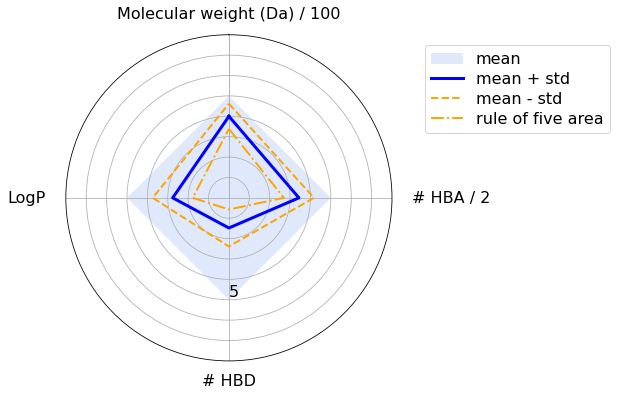

In [27]:
plot_radar(molecules_ro5_fulfilled_stats, thresholds, scaled_threshold, properties_labels, y_max)

/home/kanku.d/.local/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:371: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(Chem.MolFromSmiles)


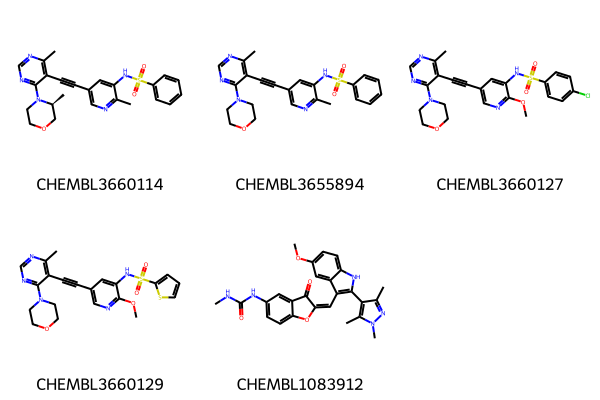

In [28]:
# Add molecule column 
PandasTools.AddMoleculeColumnToFrame(molecules_ro5_fulfilled, smilesCol="smiles") 

# Draw first 5 molecules 
Chem.Draw.MolsToGridImage( list(molecules_ro5_fulfilled.head().ROMol), legends=list(molecules_ro5_fulfilled.head().molecule_chembl_id), )

## Filter for Pan Assay Interference Compounds (PAINS)

Filtering for Pan Assay Interference Compounds (PAINS) involves identifying and removing compounds that tend to falsely appear as active hits in high-throughput screening (HTS) assays. PAINS are problematic because they exhibit activity against multiple targets rather than specifically interacting with the intended biological target. This non-specific activity can lead to misleading results and hinder the identification of genuine active compounds.

In [31]:
# initialize filter 
params = FilterCatalogParams() 
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS) 
catalog = FilterCatalog(params)

In [35]:
# Filter for Pan Assay Interference Compounds (PAINS)
matches = []
clean_indices = []

for index, row in tqdm(molecules_ro5_fulfilled.iterrows(), total=molecules_ro5_fulfilled.shape[0], desc="Filtering PAINS"):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)
    
    if entry is not None:
        # Store PAINS information
        matches.append({
            "chembl_id": row.molecule_chembl_id,
            "rdkit_molecule": molecule,
            "pains": entry.GetDescription().capitalize()
        })
    else:
        # Collect indices of molecules without PAINS
        clean_indices.append(index)

# Create DataFrame of PAINS matches
pains_df = pd.DataFrame(matches)

# Keep molecules without PAINS
compounds_df = molecules_ro5_fulfilled.loc[clean_indices]


Filtering PAINS:   0%|          | 0/3343 [00:00<?, ?it/s]

In [36]:
print(f"Number of compounds with PAINS: {len(matches)}") 
print(f"Number of compounds without PAINS: {len(compounds_df)}")

Number of compounds with PAINS: 32
Number of compounds without PAINS: 3311
